# Chapter 15: Autoencoders

Autoencoders are an unsupervised neural network architecture who are tasked with reproducing their input. They do so by learning how to encode their inputs using hidden layers that are _smaller_ than the input layer. This forces the model to learn an efficient representation of the data, called _codings_.

Below is some setup code which the author uses for the code throughout the chapter.



In [0]:
import numpy as np
import os
import sys

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# Plot styling.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Code for saving figures.
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, 'images', '{}.png'.format(fig_id))
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [0]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap='Greys', interpolation='nearest')
    plt.axis('off')

In [0]:
!mkdir images

## Performing PCA with an Undercomplete Linear Autoencoder

An autoencoder with only linear activation functions that uses MSE as the loss function can be shown to be equivalent to PCA (Chapter 8).

In [0]:
# Create a 3D dataset.

import numpy.random as rnd

rnd.seed(42)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + (np.sin(angles) / 2) + (noise * rnd.randn(m) / 2)
data[:, 1] = (np.sin(angles) * 0.7) + (noise * rnd.randn(m) / 2)
data[:, 2] = (data[:, 0] * w1) + (data[:, 1] * w2) + (noise * rnd.randn(m))

In [0]:
# Scale the data with StandardScaler.

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

In [0]:
# Define the model graph.

import tensorflow as tf

reset_graph()

n_inputs = 3
n_hidden = 2
n_outputs = n_inputs

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n_inputs))
hidden = tf.layers.dense(X, n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

opt = tf.train.AdamOptimizer(learning_rate)
training_op = opt.minimize(reconstruction_loss)

init = tf.global_variables_initializer()

In [0]:
# Training the autoencoder.

n_iterations = 100
codings = hidden

with tf.Session() as sess:
  init.run()
  for i in range(n_iterations):
    training_op.run(feed_dict={X: X_train})
  codings_val = codings.eval(feed_dict={X: X_test})

Saving figure linear_autoencoder_pca_plot


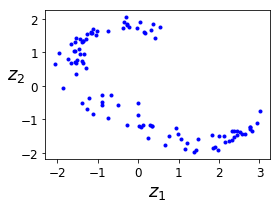

In [8]:
# Plotting the figure.

fig = plt.figure(figsize=(4,3))
plt.plot(codings_val[:,0], codings_val[:, 1], 'b.')
plt.xlabel('$z_1$', fontsize=18)
plt.ylabel('$z_2$', fontsize=18, rotation=0)
save_fig('linear_autoencoder_pca_plot')
plt.show()

## Stacked Autoencoders

Autoencoders with multiple hidden layers are called _stacked autoencoders_ (or _deep autoencoders_). You must be wary that if the autoencoder is too deep, it may just learn how to reproduce the training set, leading to overfitting. Below is a TensorFlow implementation of a stacked autoencoder with 3 hidden layers used for generating handwritten digits using the MNIST dataset.

In [10]:
# Downloading the data.

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


### Train all layers at once

The example below trains all of the hidden layers of the stacked autoencoder at once.

In [0]:
# Define the model graph.

from functools import partial

reset_graph()

n_inputs = 28 ** 2
n_hidden1 = 512
n_hidden2 = 256
n_hidden3 = n_hidden1
n_outputs = n_inputs
n_outputs = n_inputs

learning_rate = 0.001
l2_reg = 0.0001

X = tf.placeholder(tf.float32, shape=(None, n_inputs))

he_init = tf.contrib.layers.variance_scaling_initializer()
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)

dense = partial(tf.layers.dense, activation=tf.nn.relu,
                kernel_initializer=he_init, kernel_regularizer=regularizer)

hidden1 = dense(X, n_hidden1)
hidden2 = dense(hidden1, n_hidden2)
hidden3 = dense(hidden2, n_hidden3)
outputs = dense(hidden3, n_outputs, activation=None)

loss = tf.reduce_mean(tf.square(outputs - X))
opt = tf.train.AdamOptimizer(learning_rate)
training_op = opt.minimize(loss)

saver = tf.train.Saver()
init = tf.global_variables_initializer()

In [40]:
# Train the model.

n_epochs = 5
batch_size = 150

with tf.Session() as sess:
  init.run()
  for epoch in range(n_epochs):
    n_batches = mnist.train.num_examples // batch_size
    for i in range(n_batches):
      print('\r{}%'.format((100 * i) // n_batches), end="")
      sys.stdout.flush()
      X_batch, y_batch = mnist.train.next_batch(batch_size)
      sess.run(training_op, feed_dict={X: X_batch})
    loss_train = loss.eval(feed_dict={X: X_batch})
    print("\r{}".format(epoch), "Train MSE:", loss_train)
    saver.save(sess, './my_model_all_layers.ckpt')

0 Train MSE: 0.016639253
1 Train MSE: 0.01400309
2 Train MSE: 0.012794236
3 Train MSE: 0.012299093
4 Train MSE: 0.01093886


In [0]:
# Define a plotting function.

def show_reconstructed_digits(X, outputs, model_path=None, n_test_digits=2):
  with tf.Session() as sess:
    if model_path:
      saver.restore(sess, model_path)
    X_test = mnist.test.images[:n_test_digits]
    outputs_val = outputs.eval(feed_dict={X: X_test})
  for digit_idx in range(n_test_digits):
    plt.subplot(n_test_digits, 2, (digit_idx * 2) + 1)
    plot_image(X_test[digit_idx])
    plt.subplot(n_test_digits, 2, (digit_idx * 2) + 2)
    plot_image(outputs_val[digit_idx])

Saving figure reconstruction_plot


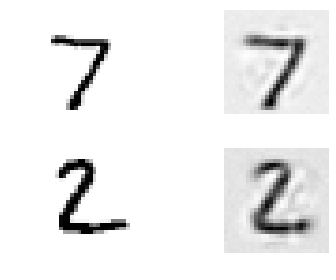

In [50]:
show_reconstructed_digits(X, outputs, './my_model_all_layers.ckpt')
save_fig('reconstruction_plot')